## ICESat-2 SlideRule Demo
## Background
### ATL03
The ATL03 data set (https://nsidc.org/data/atl03/versions/6) contains height above the WGS 84 ellipsoid (ITRF2014 reference frame), latitude, longitude, and time for all photons downlinked by the Advanced Topographic Laser Altimeter System (ATLAS) instrument on board the Ice, Cloud and land Elevation Satellite-2 (ICESat-2) observatory. The ATL03 product was designed to be a single source for all photon data and ancillary information needed by higher-level ATLAS/ICESat-2 products. As such, it also includes spacecraft and instrument parameters and ancillary data not explicitly required for ATL03.

### ATL06
The ATL06 data set (https://nsidc.org/data/atl06/versions/6) provides geolocated, land-ice surface heights (above the WGS 84 ellipsoid, ITRF2014 reference frame), plus ancillary parameters that can be used to interpret and assess the quality of the height estimates. The data were also acquired by the ATLAS instrument on board ICESat-2.

## The goal of this demo
Process ATL03 data from the Grand Mesa, CO region and produce a customized ATL06 dataset.

### What is demonstrated

* The `icesat2.atl06p` Application Programming Interface (API) is used to perform a SlideRule parallel processing request of the Grand Mesa region
* The `icesat2.cmr` and `icesat2.h5p` API's are used to manually retrieve specific ATL06 datasets corresponding to the Grand Mesa region
* The `pyproj` and `shapely` packages are used to subset ATL06 data that was manually retrieved
* The `matplotlib` package is used to plot the data processed by SlideRule alongside the manually retrieved and subsetted data

### Points of interest

The resulting datasets plotted at the bottom of the notebook show that existing ATL06 data is not available for the entire Grand Mesa region.  By using the SlideRule API to process ATL03 data and produce a customized ATL06 dataset, elevation data can be returned for the entire region of interest.

In [26]:
# Import requisite packages
import sys
import logging
import concurrent.futures
import time
from datetime import datetime
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
from shapely.geometry import Polygon, Point
from sliderule import sliderule, icesat2, earthdata, h5
import matplotlib.cm as cm
import matplotlib.colors as colors

## SlideRule Configuration

In [3]:
# Configure ICESat-2 API
icesat2.init("slideruleearth.io", verbose=True)

Client (version (4, 12, 3)) is out of date with the server (version (4, 15, 1))


In [4]:
sliderule.update_available_servers()

(7, 0)

## Specify Region of Interest

In [5]:
# Specify region of interest from geojson
poly_fn = 'grandmesa.geojson'
region = sliderule.toregion(poly_fn)["poly"]
region

[{'lon': -108.20772968780051, 'lat': 38.8232055291981},
 {'lon': -108.07460164311031, 'lat': 38.8475137825863},
 {'lon': -107.72839858755752, 'lat': 39.01510930230633},
 {'lon': -107.78724142490994, 'lat': 39.195630349659986},
 {'lon': -108.17287000970857, 'lat': 39.15920066396116},
 {'lon': -108.31168256553767, 'lat': 39.13757646212944},
 {'lon': -108.34115668325224, 'lat': 39.03758987613325},
 {'lon': -108.2878686387796, 'lat': 38.89051431295789},
 {'lon': -108.20772968780051, 'lat': 38.8232055291981}]

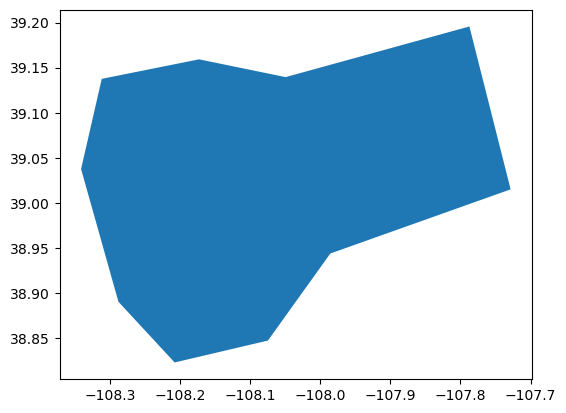

In [6]:
# Read geojson with geopandas and plot it
pregion = gpd.read_file(poly_fn)
pregion.plot();

In [7]:
# Prepare coordinate lists for plotting the region of interest polygon
region_lon = [e["lon"] for e in region]
region_lat = [e["lat"] for e in region]

## Specify parameters for ATL06-SR processing

In [8]:
# Build ATL06 Request
parms = {
    "poly": region,                  # polygon defining region of interest
    "srt": icesat2.SRT_LAND,         # surface type
    "cnf": icesat2.CNF_SURFACE_HIGH, # confidence level for photon selection
    "ats": 10.0, # minimum along track spread
    "cnt": 10,   # minimum photon count in segment
    "len": 40.0, # length of each extent in meters
    "res": 20.0  # step distance for successive extents in meters
}

## Calculate ATL06-SR Elevations from ATL03 Photons using SlideRule

In [9]:
# Latch Start Time
perf_start = time.perf_counter()

# Request ATL06 Data
atl06_sr = icesat2.atl06p(parms)

# Latch Stop Time
perf_stop = time.perf_counter()

# Display Statistics
perf_duration = perf_stop - perf_start
print("Completed in {:.3f} seconds of wall-clock time".format(perf_duration))
print("Reference Ground Tracks: {}".format(atl06_sr["rgt"].unique()))
print("Cycles: {}".format(atl06_sr["cycle"].unique()))
print("Received {} elevations".format(atl06_sr.shape[0]))

Completed in 45.729 seconds of wall-clock time
Reference Ground Tracks: [ 272  295  714  737 1156 1179  211  234]
Cycles: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
Received 456284 elevations


## Plot ATL06-SR Results

Text(37.60077129860623, 0.5, 'Latitude (°)')

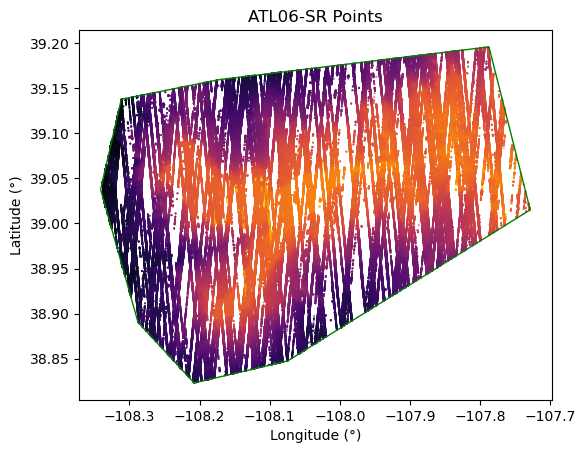

In [10]:
f, ax = plt.subplots()
ax.set_title("ATL06-SR Points") # I think SR stands for SlideRule??
ax.set_aspect('equal')
atl06_sr.plot(ax=ax, column='h_mean', cmap='inferno', s=0.1)
ax.plot(region_lon, region_lat, linewidth=1, color='g');
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')

In [11]:
# display ATL06-SR data
atl06_sr

,h_sigma,spot,cycle,x_atc,region,w_surface_window_final,h_mean,n_fit_photons,pflags,segment_id,dh_fit_dx,rgt,rms_misfit,gt,y_atc,geometry
time,,,,,,,,,,,,,,,,
2018-10-16 10:49:21.177004288,0.111745,6,1,15708287.0,6,3.642701,1932.724302,31,0,784256,0.033667,272,0.604252,10,44675.378906,POINT (-108.05598 39.17009)
2018-10-16 10:49:21.180020480,0.095391,6,1,15708307.0,6,4.146861,1934.069145,52,0,784257,0.087854,272,0.662935,10,44674.816406,POINT (-108.05601 39.16991)
2018-10-16 10:49:21.183400960,0.085968,6,1,15708327.0,6,4.299329,1935.859843,49,0,784258,0.081110,272,0.589985,10,44674.156250,POINT (-108.05605 39.16971)
2018-10-16 10:49:21.186394368,0.103511,6,1,15708347.0,6,4.377315,1937.363736,29,0,784259,0.085489,272,0.552829,10,44673.578125,POINT (-108.05608 39.16953)
2018-10-16 10:49:21.189383680,0.228836,6,1,15708367.0,6,5.491649,1939.724812,24,0,784260,0.156731,272,1.105599,10,44672.921875,POINT (-108.05611 39.16935)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-01 19:35:14.381412352,0.039116,3,26,15748581.0,6,3.000000,1809.241517,77,0,786276,0.009599,1156,0.337297,30,53.955978,POINT (-108.09533 38.84831)
2025-03-01 19:35:14.384235264,0.143267,3,26,15748601.0,6,3.000000,1809.442963,31,0,786277,0.012008,1156,0.359424,30,54.076244,POINT (-108.09535 38.84813)
2025-03-01 19:35:14.483593728,0.044556,5,26,15749423.0,6,3.000000,1939.807796,31,0,786318,-0.085055,1156,0.185644,50,-3140.267578,POINT (-108.13288 38.8435)


In [12]:
# Build ATL06 Request
parms = {
    "poly": region,                  # polygon defining region of interest
    "srt": icesat2.SRT_LAND,         # surface type
    "cnf": icesat2.CNF_SURFACE_HIGH, # confidence level for photon selection
    "ats": 10.0, # minimum along track spread
    "cnt": 10,   # minimum photon count in segment
    "len": 40.0, # length of each extent in meters
    "res": 20.0, # step distance for successive extents in meters
    "output": {
        "path": "output.geoparquet",
        "format": "parquet",
        "as_geo": True,
        "open_on_complete": True
    }
}

In [13]:
# Latch Start Time
perf_start = time.perf_counter()

# Request ATL06 Data
atl06_sr = icesat2.atl06p(parms)

# Latch Stop Time
perf_stop = time.perf_counter()

# Display Statistics
perf_duration = perf_stop - perf_start
print("Completed in {:.3f} seconds of wall-clock time".format(perf_duration))
print("Reference Ground Tracks: {}".format(atl06_sr["rgt"].unique()))
print("Cycles: {}".format(atl06_sr["cycle"].unique()))
print("Received {} elevations".format(atl06_sr.shape[0]))

Completed in 40.241 seconds of wall-clock time
Reference Ground Tracks: [1156  211 1179  714  737  295  234  272]
Cycles: [ 6 25 10  1 18  5  7 11 16 12 21  2 20 22 14  3 19  8 24 23 17  9 13 15
  4 26]
Received 456284 elevations


Text(37.60077129860623, 0.5, 'Latitude (°)')

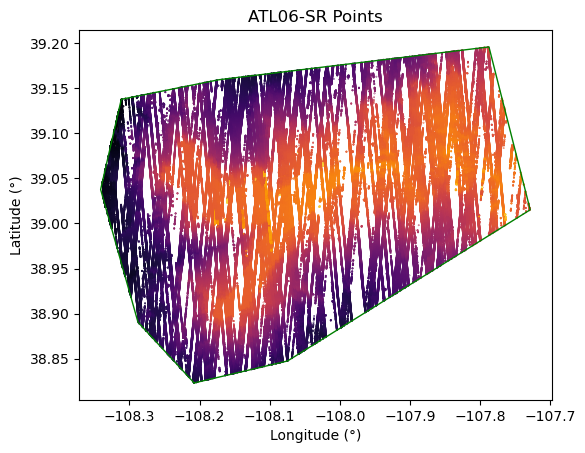

In [14]:
# Create plots
f, ax = plt.subplots()
ax.set_title("ATL06-SR Points")
ax.set_aspect('equal')
atl06_sr.plot(ax=ax, column='h_mean', cmap='inferno', s=0.1)
ax.plot(region_lon, region_lat, linewidth=1, color='g')
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')

In [15]:
# Build ATL06 Request
parms = {
    "poly": region,                  # polygon defining region of interest
    "srt": icesat2.SRT_LAND,         # surface type
    "cnf": icesat2.CNF_SURFACE_HIGH, # confidence level for photon selection
    "ats": 10.0, # minimum along track spread
    "cnt": 10,   # minimum photon count in segment
    "len": 40.0, # length of each extent in meters
    "res": 20.0, # step distance for successive extents in meters
    "output": {
        "path": "output.geoparquet",
        "format": "parquet",
        "as_geo": False,
        "open_on_complete": False
    }
}

In [16]:
# Latch Start Time
perf_start = time.perf_counter()

# Request ATL06 Data
atl06_sr = icesat2.atl06p(parms)

# Latch Stop Time
perf_stop = time.perf_counter()

# Display Statistics
perf_duration = perf_stop - perf_start
print("Completed in {:.3f} seconds of wall-clock time".format(perf_duration))
print(atl06_sr)

Completed in 40.566 seconds of wall-clock time
output.geoparquet


In [17]:
df = gpd.pd.read_parquet("output.geoparquet")
geometry = gpd.points_from_xy(df["longitude"], df["latitude"])
atl06_sr = gpd.GeoDataFrame(df, geometry=geometry)

Text(24.847222222222214, 0.5, 'Latitude (°)')

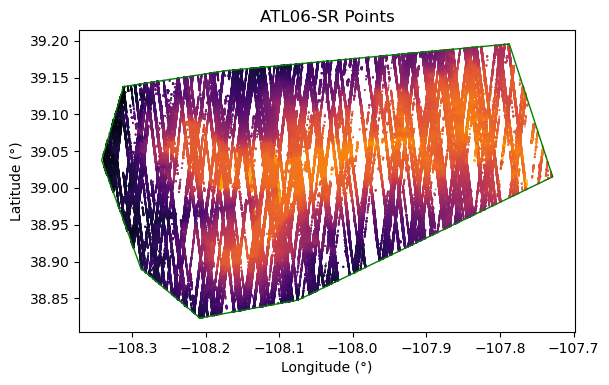

In [18]:
f, ax = plt.subplots()
ax.set_title("ATL06-SR Points")
ax.set_aspect('equal')
atl06_sr.plot(ax=ax, column='h_mean', cmap='inferno', s=0.1)
ax.plot(region_lon, region_lat, linewidth=1, color='g')
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')

## Retrieve ATL06 Elevations Directly using `icesat2.h5p` API

This method of reading H5 data directly is the recommended method and runs faster than `icesat2.h5` as each dataset is read in parallel on the server and shares a common cache. The code below has a couple of other optimizations including only sampling every 10th coordinate for point inclusion, and reading the lat,lon information first and then reading only the necessary heights.  

See https://nsidc.org/data/atl06 for the source dataset.

In [21]:
# read ATL06 resource and return heights within polygon
def subsetted_read(resource, polygon, transformer):

    heights = []
    latitudes = []
    longitudes = []
    api_time = 0

    try:

        # List of tracks to read
        tracks = ["1l", "1r", "2l", "2r", "3l", "3r"]

        # Build list of each lat,lon dataset to read
        geodatasets = []
        for track in tracks:
            prefix = "/gt"+track+"/land_ice_segments/"
            geodatasets.append({"dataset": prefix+"latitude", "startrow": 0, "numrows": -1})
            geodatasets.append({"dataset": prefix+"longitude", "startrow": 0, "numrows": -1})

        # Read lat,lon from resource
        api_start = time.perf_counter()
        geocoords = h5.h5p(geodatasets, resource, "icesat2")
        api_stop = time.perf_counter()
        api_time += (api_stop - api_start)
        
        # Build list of the subsetted h_li datasets to read
        hidatasets = []
        for track in tracks:
            prefix = "/gt"+track+"/land_ice_segments/"
            lat_dataset = geocoords[prefix+"latitude"]
            lon_dataset = geocoords[prefix+"longitude"]
            startrow = -1
            numrows = -1
            index = 0
            while index < len(lat_dataset):
                lat = lat_dataset[index]
                lon = lon_dataset[index]
                c = transformer.transform(lat, lon)
                point = Point(c[0], c[1])
                intersect = point.within(polygon)
                if startrow == -1 and intersect:
                    startrow = index
                elif startrow != -1 and not intersect:
                    break
                index += 10 # only sample values for speed increase
            if startrow >= 0:
                numrows = index - startrow
            if numrows > 0:
                hidatasets.append({"dataset": prefix+"h_li", "startrow": startrow, "numrows": numrows, "prefix": prefix})

        # Read h_li from resource
        if len(hidatasets) > 0:
            api_start = time.perf_counter()
            hivalues = h5.h5p(hidatasets, resource, "icesat2")
            api_stop = time.perf_counter()
            api_time += (api_stop - api_start)

        # Append results
        for entry in hidatasets:
            heights += hivalues[entry["prefix"]+"h_li"].tolist()
            latitudes += geocoords[entry["prefix"]+"latitude"][entry["startrow"]:entry["startrow"]+entry["numrows"]].tolist()
            longitudes += geocoords[entry["prefix"]+"longitude"][entry["startrow"]:entry["startrow"]+entry["numrows"]].tolist()

    except Exception as e:
        pass
        
    # Return results
    return {"resource":  resource,
            "h_li":      heights,
            "latitude":  latitudes,
            "longitude": longitudes,
            "time":      api_time}

In [22]:
# Initialize Total Time Spent Inside API
api_total_time = 0

# Latch Start Time
perf_start = time.perf_counter() # NameError: name 'time' is not defined

# Query ATL06 Files from NASA CMR System
resources = earthdata.cmr(polygon=region, short_name='ATL06')
print('Retrieved %s resources that intersect region' % (len(resources)))

# Create Projection Transformer
transformer = Transformer.from_crs(4326, 3857) # GPS to Web Mercator

# Project Polygon
pregion = []
for point in region:
    ppoint = transformer.transform(point["lat"], point["lon"])
    pregion.append(ppoint)
polygon = Polygon(pregion)

# Initialize Result Dataset
results = {"latitude": [], "longitude": [], "h_li":[]}

# Update Available Servers #
num_servers, _ = sliderule.update_available_servers()
print('Allocating %d workers across %d processing nodes' % (num_servers, num_servers))

# Make Parallel Processing Requests
with concurrent.futures.ThreadPoolExecutor(max_workers=num_servers) as executor:
    futures = [executor.submit(subsetted_read, resource, polygon, transformer) for resource in resources]
    # Wait for Results
    result_cnt = 0
    for future in concurrent.futures.as_completed(futures):
        result_cnt += 1
        result = future.result()
        print('%d results returned for %s (%d out of %d)' % (len(result["h_li"]), result["resource"], result_cnt, len(resources)))
        results["h_li"] += result["h_li"]
        results["latitude"] += result["latitude"]
        results["longitude"] += result["longitude"]
        api_total_time += result["time"]

# Latch Stop Time
perf_stop = time.perf_counter()
perf_duration = perf_stop - perf_start

# Build GeoDataframe of ATL06 Standard Data Product
geometry = gpd.points_from_xy(results["longitude"], results["latitude"])
df = gpd.pd.DataFrame(results)
atl06_sdp = gpd.GeoDataFrame(df, geometry=geometry)

# Filter Height Values
atl06_sdp = atl06_sdp[atl06_sdp["h_li"] < 10000]

# Print Statistics
print("Completed in {:.3f} seconds of wall-clock time".format(perf_duration))
print("Spent {:.3f} concurrent seconds waiting for api".format(api_total_time))
print("Retrieved {} valid elevations out of {} total elevations".format(len(atl06_sdp), len(results["h_li"])))

Retrieved 147 resources that intersect region
Allocating 7 workers across 7 processing nodes
350 results returned for ATL06_20190111063212_02110206_006_02.h5 (1 out of 147)
1020 results returned for ATL06_20181017222812_02950102_006_02.h5 (2 out of 147)
3940 results returned for ATL06_20181114092019_07140106_006_02.h5 (3 out of 147)
0 results returned for ATL06_20190116180755_02950202_006_02.h5 (4 out of 147)
11110 results returned for ATL06_20181016104402_02720106_006_02.h5 (5 out of 147)
10340 results returned for ATL06_20181115210428_07370102_006_02.h5 (6 out of 147)
7220 results returned for ATL06_20181214194017_11790102_006_02.h5 (7 out of 147)
7420 results returned for ATL06_20181213075606_11560106_006_02.h5 (8 out of 147)
2910 results returned for ATL06_20190213050003_07140206_006_02.h5 (9 out of 147)
20 results returned for ATL06_20190214164413_07370202_006_02.h5 (10 out of 147)
2500 results returned for ATL06_20190314033606_11560206_006_02.h5 (11 out of 147)
20 results returne

## Trim ATL06 points to region polygon

In [23]:
# Create shapely polygon
pregion = Polygon(zip(region_lon, region_lat))

# Using geopandas
idx = atl06_sdp.within(pregion)
atl06_sdp = atl06_sdp[idx]

## Plot ATL06-SR vs. ATL06

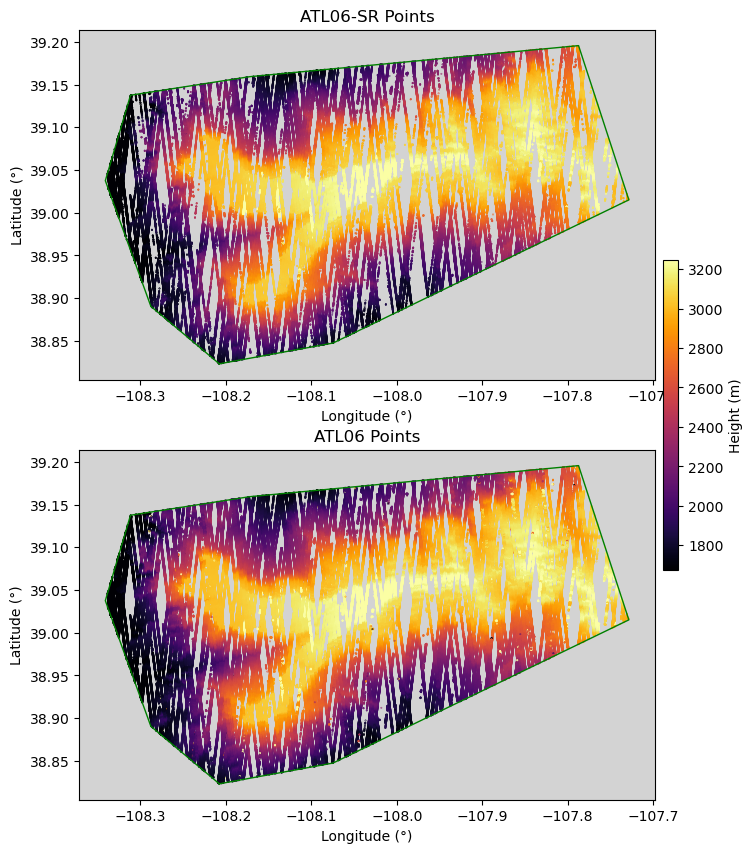

In [27]:
# Set color ramp limits
vmin, vmax = atl06_sdp['h_li'].quantile((0.02, 0.98))

# Create dictionary of common keyword arguments
plot_kw = {'cmap':'inferno', 's':0.1, 'vmin':vmin, 'vmax':vmax}

f, axa = plt.subplots(2,1, figsize=(10,10)) # sharex=True, sharey=True
axa[0].set_title("ATL06-SR Points")
atl06_sr.plot(ax=axa[0], column='h_mean', **plot_kw)
axa[1].set_title("ATL06 Points")
atl06_sdp.plot(ax=axa[1], column='h_li', **plot_kw)

for ax in axa:
    # Plot the region polygon
    ax.plot(region_lon, region_lat, linewidth=1, color='g')
    ax.set_aspect('equal');
    ax.set_facecolor('lightgray')
    ax.set_xlabel('Longitude (°)')
    ax.set_ylabel('Latitude (°)')
# Add colorbar
norm = colors.Normalize(vmin=vmin, vmax=vmax)
sm = cm.ScalarMappable(cmap='inferno', norm=norm)
sm._A = []  # Only needed for older versions of matplotlib
cbar = f.colorbar(sm, ax=axa, orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label("Height (m)")